In [1]:
import pandas as pd
import dfply as df
import seaborn as sns
import m2.dfply_utils as dfu
from scipy import signal

In [2]:
agregados_monetarios = pd.read_csv('./data/agregados-monetarios.csv')

In [3]:
diff_m = (
    agregados_monetarios 
    >> df.select('indice_tiempo', 'base_monetaria_total') 
    >> df.mutate(diff_m=df.X.base_monetaria_total.diff() / df.X.base_monetaria_total * 100)
    >> df.mask(~df.X.diff_m.isna())
)

In [4]:
precios = pd.read_csv('./data/indice-precios-al-consumidor-apertura-por-categorias-base-diciembre-2016-mensual.csv')

In [5]:
diff_ipc = (
    precios 
    >> df.select('indice_tiempo', 'ipc_nivel_general_nacional')
    >> df.mutate(diff_ipc=df.X.ipc_nivel_general_nacional.diff() / df.X.ipc_nivel_general_nacional * 100)
    >> df.mask(~df.X.diff_ipc.isna())
)

In [6]:
df_to_datetime = df.make_symbolic(pd.to_datetime)

In [7]:
m_vs_ipc = (
    diff_ipc 
    >> df.left_join(diff_m, by='indice_tiempo')
    >> df.mutate(date=df_to_datetime(df.X.indice_tiempo))
    >> df.mutate(year=df.X.date.apply(lambda d: d.year))
)

In [8]:
m_vs_ipc_sum = (
    m_vs_ipc
    >> df.arrange(df.X.date)
    >> df.group_by('year')
    >> df.summarize(
        diff_ipc=(
            (df.X.ipc_nivel_general_nacional.iloc[-1] - df.X.ipc_nivel_general_nacional.iloc[0]) /
            df.X.ipc_nivel_general_nacional.iloc[0]
        ),
        diff_m=(
            (df.X.base_monetaria_total.iloc[-1] - df.X.base_monetaria_total.iloc[0]) / 
            df.X.base_monetaria_total.iloc[0]
        ),
    )
)

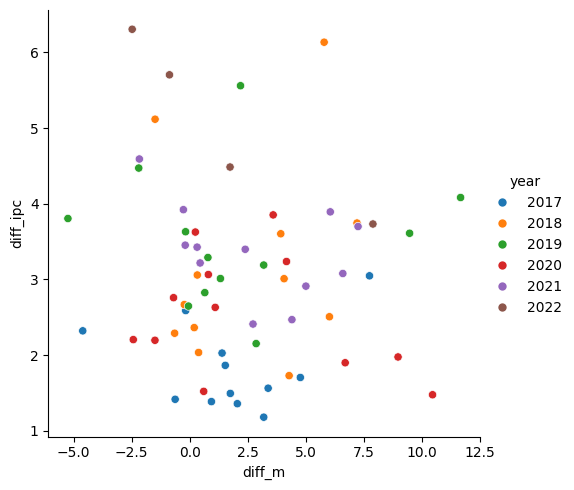

In [9]:
sns.relplot(data=m_vs_ipc, x='diff_m', y='diff_ipc', hue='year', palette='tab10')

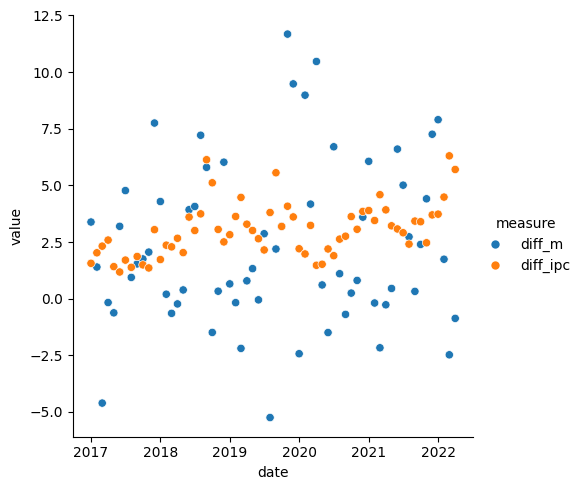

In [10]:
sns.relplot(
    data=m_vs_ipc >> df.gather('measure', 'value', ['diff_m', 'diff_ipc']),
    x='date', y='value', hue='measure'
)

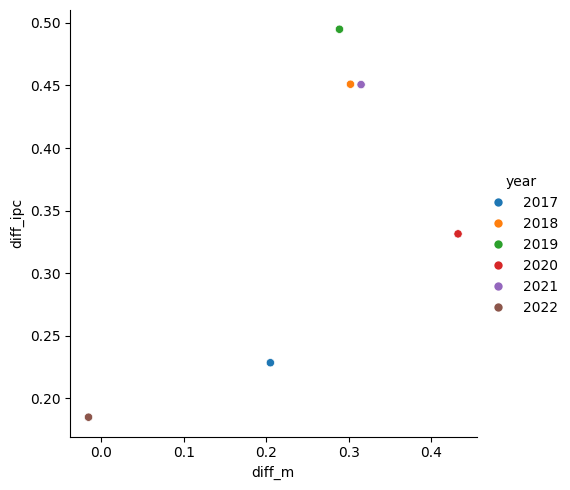

In [11]:
sns.relplot(data=m_vs_ipc_sum, x='diff_m', y='diff_ipc', hue='year', palette='tab10')

In [24]:
sns.scatterplot?

<Axes: title={'center': 'INDICATOR = M3'}, xlabel='monetary_diff', ylabel='diff_ipc'>

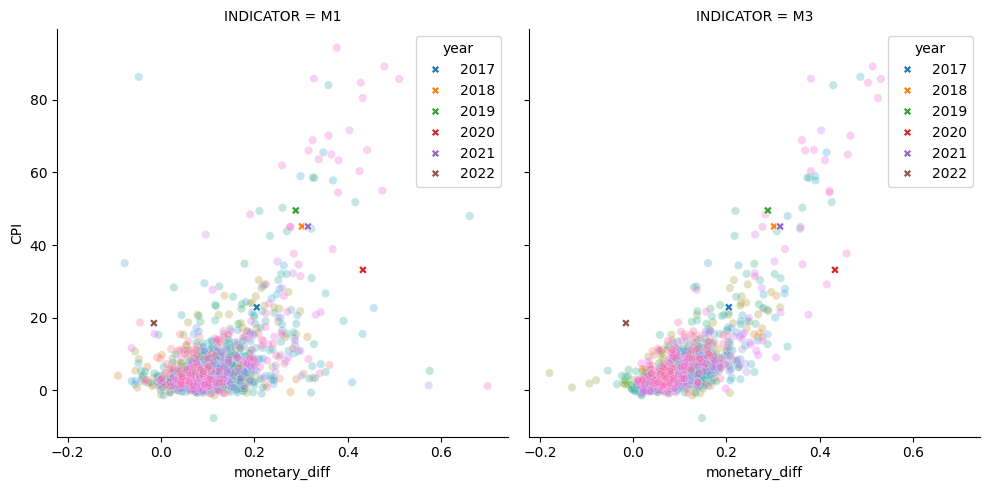

In [31]:
joined = pd.read_csv('data/cpi_vs_m.csv')
fg = sns.relplot(data=joined, x='monetary_diff', y='CPI', col='INDICATOR', hue='LOCATION', alpha=0.3, legend=False)
sns.scatterplot(data=m_vs_ipc_sum >> df.mutate(diff_ipc=df.X.diff_ipc * 100), x='diff_m', y='diff_ipc', hue='year', palette='tab10', marker='X', ax=fg.axes[0][0])
sns.scatterplot(data=m_vs_ipc_sum >> df.mutate(diff_ipc=df.X.diff_ipc * 100), x='diff_m', y='diff_ipc', hue='year', palette='tab10', marker='X', ax=fg.axes[0][1])

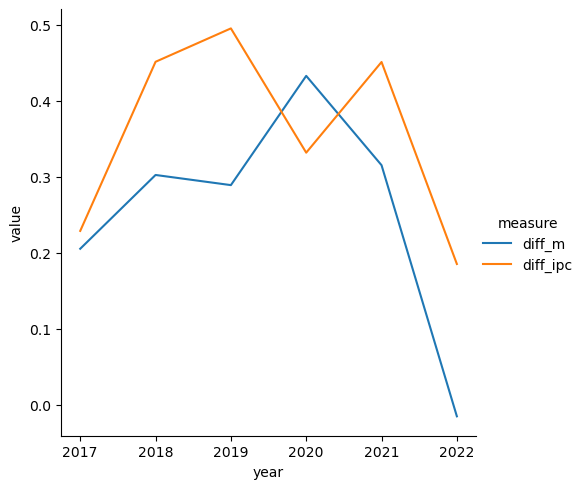

In [22]:
sns.relplot(
    data=m_vs_ipc_sum >> df.gather('measure', 'value', ['diff_m', 'diff_ipc']),
    x='year', y='value', hue='measure', kind='line'
)

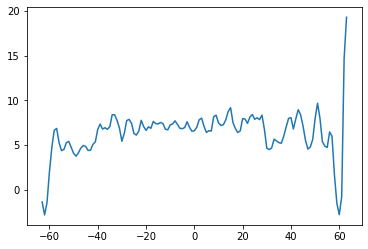

In [55]:
lags = np.arange(-m_vs_ipc.shape[0] + 1, m_vs_ipc.shape[0])
overlap = m_vs_ipc.shape[0] - np.abs(lags)
m_vs_ipc_corr = signal.correlate(m_vs_ipc.diff_ipc, m_vs_ipc.diff_m) 
m_vs_ipc_corr_rel = m_vs_ipc_corr / overlap
plt.plot(lags, m_vs_ipc_corr_rel)

In [13]:
rel_m = (
    agregados_monetarios
    >> df.select('indice_tiempo', 'base_monetaria_total')
    >> df.mutate(base_monetaria_total=(df.X.base_monetaria_total / df.X.base_monetaria_total.iloc[0]) * 100)
)

In [14]:
rel_ipc = (
    precios
    >> df.select('indice_tiempo', 'ipc_nivel_general_nacional')
    >> df.rename(ipc=df.X.ipc_nivel_general_nacional)
    >> df.mutate(ipc=(df.X.ipc / df.X.ipc.iloc[0]) * 100)
)

In [20]:
ipc_and_m = (
    rel_m
    >> df.left_join(rel_ipc, by='indice_tiempo')
    >> df.mask(~df.X.ipc.isna())
    >> df.gather('tipo', 'valor', ['ipc', 'base_monetaria_total'])
)

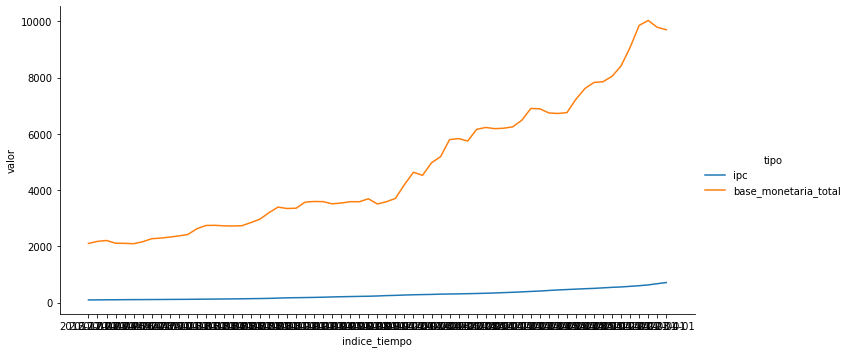

In [22]:
sns.relplot(data=ipc_and_m, x='indice_tiempo', y='valor', hue='tipo', kind='line', aspect=2)

In [43]:
ipc_hist

,indice_tiempo,nivel_general,alimentos_bebidas,indumentaria,vivienda_servicios_basicos,equipamiento_mantenimiento_hogar,atencion_medica_salud,transporte_comunicaciones,esparcimiento,educacion,bienes_servicios_varios
0,1943-01-01,2.050490e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1943-02-01,2.038620e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1943-03-01,2.070780e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1943-04-01,2.084520e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1943-05-01,2.066410e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
779,2007-12-01,2.024900e+02,232.97,227.01,169.69,200.40,190.56,172.32,205.52,177.11,216.26
780,2008-01-01,2.043700e+02,234.50,222.28,171.95,201.06,192.97,175.61,210.57,178.09,217.20
781,2008-02-01,2.053300e+02,237.16,216.23,173.58,202.50,193.80,175.10,210.79,179.63,218.40
782,2008-03-01,2.076500e+02,239.85,216.73,174.79,204.08,195.40,176.27,213.21,193.26,219.74


In [53]:
ipc_hist.nivel_general.iloc[-1]

209.37

In [57]:
ipc_hist = (
    pd.read_csv('./data/ipc-historico.csv', converters=dict(indice_tiempo=pd.to_datetime))
    >> df.mutate(diff_ipc=df.X.nivel_general.diff() / df.X.nivel_general)
)
ipc_hist_year = (
    ipc_hist 
    >> df.mutate(year=df.X.indice_tiempo.apply(lambda x: x.year))
    >> df.group_by('year')
    >> df.mutate(diff_ipc=(df.X.nivel_general.iloc[-1] - df.X.nivel_general.iloc[0]) / df.X.nivel_general.iloc[0])
)

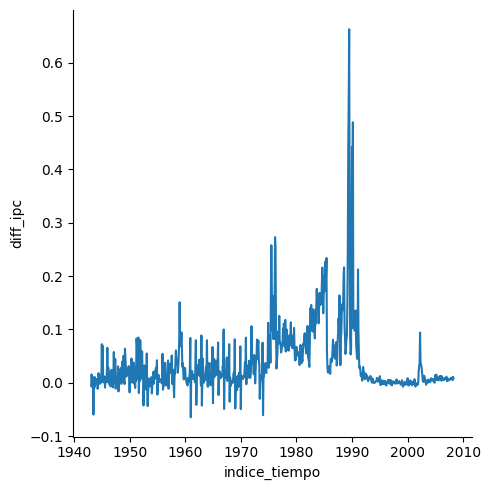

In [58]:
sns.relplot(data=ipc_hist, x='indice_tiempo', y='diff_ipc', kind='line')

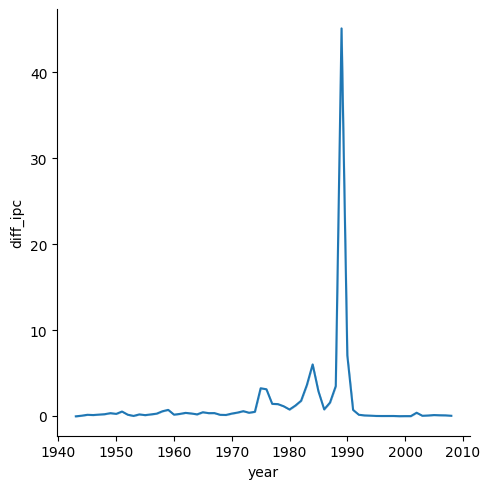

In [59]:
sns.relplot(data=ipc_hist_year, x='year', y='diff_ipc', kind='line')

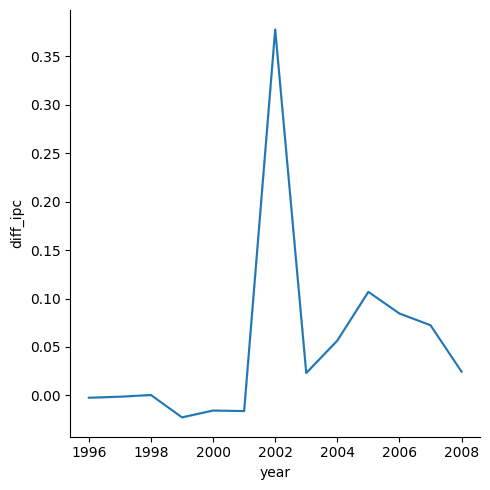

In [62]:
sns.relplot(data=ipc_hist_year >> df.mask(df.X.year > 1995), x='year', y='diff_ipc', kind='line')